In [1]:
import sys
sys.path.insert(0, '../../bin')

import sirius
import json
import copy
from bands import plotter

In [2]:
baseparameters = {
    "control" : {
        "cyclic_block_size" : 16,
        "processing_unit" : "cpu",
        "std_evp_solver_type" : "lapack",
        "gen_evp_solver_type" : "lapack",
        "verbosity" : 2,
        "verification" : 0,
        "print_memory_usage" : False,
        "print_checksum" : False,
        "print_forces" : True,
        "print_stress" : True
    },

    "!settings" : {
      "always_update_wf" : False
    },

    "parameters" : {

        "num_fv_states" : 40,

        "xc_functionals" : ["XC_LDA_X", "XC_LDA_C_PZ"],

        "smearing_width" : 0.025,

        "use_symmetry" : True,

        "num_mag_dims" : 0,

        "gk_cutoff" : 6.0,
        "pw_cutoff" : 20.00,

        "energy_tol" : 1e-8,
        "potential_tol" : 1e-8,

        "num_dft_iter" : 1,

        "ngridk" : [2,2,2],
        "gamma_point" : False
    },

    "unit_cell" : {

        "lattice_vectors" : [ [1, 0, 0],
                              [0, 1, 0],
                              [0, 0, 1]
                            ],
        "lattice_vectors_scale" : 7.260327248,

        "atom_types" : ["Sr", "V", "O"],

        "atoms" : {
            "Sr" : [
                [0.5, 0.5, 0.5]
            ],
            "V" : [
                [0, 0, 0, 0, 0, 4]
            ],
            "O" : [
                [0.5, 0.0, 0.0],
                [0.0, 0.5, 0.0],
                [0.0, 0.0, 0.5]
            ]
        }
    },

    "mixer" : {
        "beta" : 0.95,
        "type" : "broyden1",
        "max_history" : 8
    },

    "kpoints_rel": {
    "K": [
      0.375,
      0.375,
      0.75
    ],
    "L": [
      0.5,
      0.5,
      0.5
    ],
    "U": [
      0.625,
      0.25,
      0.625
    ],
    "W": [
      0.5,
      0.25,
      0.75
    ],
    "X": [
      0.5,
      0.0,
      0.5
    ],
    "GAMMA": [
      0.0,
      0.0,
      0.0
    ],
    "W_2": [
      0.75,
      0.25,
      0.5
    ]
  },

  "kpoints_path" : ["GAMMA", "K", "L"]

}

In [50]:
def calculate_bands(param):
    ctx = sirius.Simulation_context(json.dumps(param))
    ctx.set_gamma_point(False)
    ctx.initialize()

    dft = sirius.DFT_ground_state(ctx)
    dft.initial_state()

    result = dft.find(ctx.parameters_input().potential_tol_, ctx.parameters_input().energy_tol_, ctx.parameters_input().num_dft_iter_, True)
    dft.print_magnetic_moment()

    if param["parameters"]["electronic_structure_method"] == "pseudopotential":
        ctx.set_iterative_solver_tolerance(1e-12)

    potential = sirius.Potential(ctx)
    potential.allocate()

    H = sirius.Hamiltonian(ctx, potential)

    density = sirius.Density(ctx)
    density.allocate()

    ks = sirius.K_point_set(ctx)
    print("Total Energy = ", dft.total_energy())


    x_axis = []
    x_ticks = []


    index = param["kpoints_path"]

    vertex = []

    for i in enumerate(index):
        v = param["kpoints_rel"][i[1]]
        print(i[1])
        vertex.append((i[1],v))

    x_axis.append(0)
    x_ticks.append((0, vertex[0][0]))
    print("vertex[0][1] =", vertex[0][1])
    print("type(vertex[0][1]) = ", type(vertex[0][1]))
    print("len(vertex)=", len(vertex))
    ks.add_kpoint(vertex[0][1], 1.0)

    t = 0
    print(vertex)
    for i in range(len(vertex)-1):
        v0 = sirius.vector3d_double(vertex[i][1])
        v1 = sirius.vector3d_double(vertex[i+1][1])
        dv = v1 - v0
        dv_cart = ctx.unit_cell().reciprocal_lattice_vectors() * dv
        np = max(10, int(30*dv_cart.length()))
        for j in range(1, np+1):
            v = sirius.vector3d_double(v0 + dv*(float(j)/np))
            ks.add_kpoint(v, 1.0)
            t += dv_cart.length()/np
            x_axis.append(t)
        x_ticks.append((t, vertex[i+1][0]))


    counts = []
    ks.initialize()

    density.load()
    potential.generate(density)

    band = sirius.Band(ctx)
    if param["parameters"]["electronic_structure_method"] == "pseudopotential":
        band.initialize_subspace(ks, H)

    band.solve(ks, H, True)
    #print("Fermi-Energy = ", ks.energy_fermi())
    #ks.sync_band_energies()
    print("Calculation finished.")
    return ctx, ks, x_ticks, x_axis

In [134]:
def make_dict(ctx, ks, x_ticks, x_axis):
    dict = {}
    dict["header"] = {}
    dict["header"]["x_axis"] = x_axis
    dict["header"]["x_ticks"]=[]
    dict["header"]["num_bands"]=ctx.num_bands()
    dict["header"]["num_mag_dims"] = ctx.num_mag_dims()

    for e in enumerate(x_ticks):
        j = {}
        j["x"] = e[1][0]
        j["label"] = e[1][1]
        dict["header"]["x_ticks"].append(j)

    dict["bands"] = []

    for ik in range(ks.num_kpoints()):
        bnd_k = {}
        bnd_k["kpoint"] = [0.0,0.0,0.0]
        for x in range(3):
            bnd_k["kpoint"][x] = ks(ik).vk()(x)
            if ik == 32:
                print(bnd_k["kpoint"][x])
        bnd_e = []

        for ispn in range(ctx.num_spin_dims()):
            for j in range(ctx.num_bands()):
                bnd_e.append(ks(ik).band_energy(j, ispn)+0.23)


        bnd_k["values"] = bnd_e
        dict["bands"].append(bnd_k)
    return dict

In [109]:
param_pp = copy.deepcopy(baseparameters)
param_pp["parameters"]["electronic_structure_method"] = "pseudopotential"
param_pp["iterative_solver"] = {
    "!energy_tolerance" : 1e-2,
    "!residual_tolerance" : 1e-6,
    "num_steps" : 20,
    "subspace_size" : 4,
    "type" : "davidson",
    "converge_by_energy" : 1,
    "!orthogonalize" : False,
    "!init_subspace" : "lcao",
    "init_eval_old" : False
}
param_pp["unit_cell"]["atom_files"] = {
    "Sr" : "sr_lda_v1.uspp.F.UPF.json",
    "V"  : "v_lda_v1.4.uspp.F.UPF.json",
    "O"  : "o_lda_v1.2.uspp.F.UPF.json"
}


param_fp = copy.deepcopy(baseparameters)
param_fp["parameters"]["electronic_structure_method"] = "full_potential_lapwlo"
param_fp["unit_cell"]["atom_files"] = {
    "Sr" : "/Users/colinkalin/my_SIRIUS/examples/old/2.SrVO3_fp/Sr.json",
    "V"  : "/Users/colinkalin/my_SIRIUS/examples/old/2.SrVO3_fp/V.json",
    "O"  : "/Users/colinkalin/my_SIRIUS/examples/old/2.SrVO3_fp/O.json"
}

In [5]:
sirius.initialize()

In [64]:
ctx, ks, x_ticks, x_axis = calculate_bands(param_pp)

Total Energy =  -157.41396461847017
GAMMA
K
L
vertex[0][1] = [0.0, 0.0, 0.0]
type(vertex[0][1]) =  <class 'list'>
len(vertex)= 3
[('GAMMA', [0.0, 0.0, 0.0]), ('K', [0.375, 0.375, 0.75]), ('L', [0.5, 0.5, 0.5])]
0.48749999701976776
0.48749999701976776
0.5250000059604645


In [73]:
ctx2, ks2, x_ticks2, x_axis2 = calculate_bands(param_fp)

Total Energy =  -4359.784035607341
GAMMA
K
L
vertex[0][1] = [0.0, 0.0, 0.0]
type(vertex[0][1]) =  <class 'list'>
len(vertex)= 3
[('GAMMA', [0.0, 0.0, 0.0]), ('K', [0.375, 0.375, 0.75]), ('L', [0.5, 0.5, 0.5])]


In [115]:
dict1 = make_dict(ctx, ks, x_ticks, x_axis)

0.48749999701976776
0.48749999701976776
0.5250000059604645


In [135]:
dict2 = make_dict(ctx2, ks2, x_ticks2, x_axis2)

0.48749999701976776
0.48749999701976776
0.5250000059604645


num_bands1= 40
num_bands2= 40


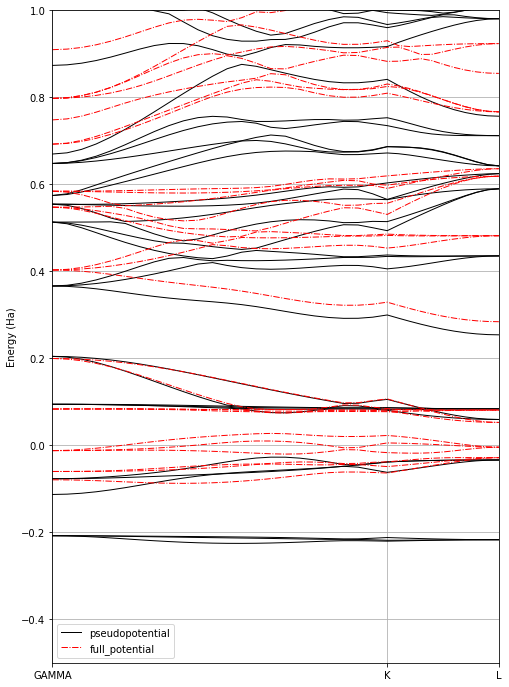

In [136]:
plotter(dict1, "pseudopotential", dict2, "full_potential", True)

In [ ]:
dft = None
ctx = None

sirius.finalize()